## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to be applied on STM32 Nucleo Board.

Questa parte di codice serve solo per essere compatibile con la OpenMV Cam

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
import random
import os
import csv 
import tempfile

# Absolute path is needed to load libraries 
import sys
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

from lib.frozen_lib import *

Load MNIST dataset and split in training and test

In [50]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


# Options

In [51]:
# Define High and Low sets
low_set = set(range(0,6))
high_set = set(range(6,10))

# test elements
n_elem_low = 50   # Number of elements for each label to add in data_low_test
n_elem_high = 50  # Number of elements for each label to add in data_high_test

# Training
epochs = 40
batch_size = 32

## Save path
if(n_elem_low == n_elem_high):
  n_elem = str(n_elem_low)
else:
  n_elem = str(n_elem_low) + '_' + str(n_elem_high)


SAVE_MODEL_PATH = ROOT_PATH + "/Models/" + str(n_elem) + "/"

Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [52]:
# New separation script
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]
img_rows, img_cols = 28, 28

trainLow_samples = 0
testLow_samples = 0
for lbl in low_set:
    trainLow_samples += (label_train == lbl).sum()
    testLow_samples += (label_test == lbl).sum()

# SPLIT TRAIN DATA
# Split train dataset in high and low
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i]<6):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1

# SPLIT TEST DATA
# Split test dataset in high and low. Number of testing elements is predefined
n_low = n_elem_low * len(low_set)
n_high = n_elem_high * len(high_set)

data_low_test   = np.zeros([n_low,28,28])
label_low_test  = np.zeros(n_low)
data_high_test  = np.zeros([n_high,28,28])
label_high_test = np.zeros(n_high)

digits_set = low_set.union(high_set)
counter = {x: 0 for x in digits_set}

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i] in low_set):
        if(counter[label_test[i]] < n_elem_low):
            data_low_test[j,:,:] = data_test[i,:,:]
            label_low_test[j]    = label_test[i]
            counter[label_test[i]] += 1
            j += 1
    else:
        if(counter[label_test[i]] < n_elem_high):
            data_high_test[k,:,:] = data_test[i,:,:]
            label_high_test[k]    = label_test[i]
            counter[label_test[i]] += 1
            k += 1   

print('After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:')
print(f'     Train dataset lower than 6 has shape:  {data_low_train.shape}')
print(f'     Train dataset higher than 6 has shape: {data_high_train.shape}')
print()
print(f'     Test dataset lower than 6 has shape:  {data_low_test.shape}')
print(f'     Test dataset higher than 6 has shape: {data_high_test.shape}')

After the separation of the dataset in groups higer and lower/equal than 6 the datasets are:
     Train dataset lower than 6 has shape:  (36017, 28, 28)
     Train dataset higher than 6 has shape: (23983, 28, 28)

     Test dataset lower than 6 has shape:  (300, 28, 28)
     Test dataset higher than 6 has shape: (200, 28, 28)


10
7.0


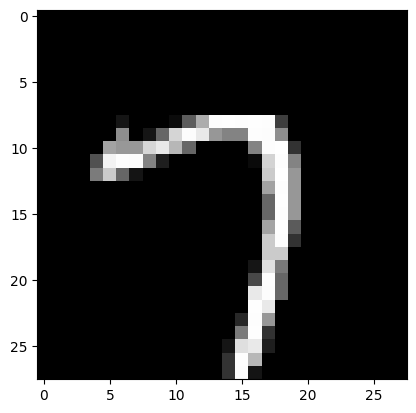

In [53]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,20))
print(num)
plt.imshow(data_high_test[num], cmap="gray") # Import the image
print(label_high_test[num])
plt.show() # Plot the image

## **Pre process the data**

In [54]:
# Something I don't know
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

# Normalize the colors from 0-255 to 0-1
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0

## **BUILD THE MODEL**

In [55]:
# Model selection
TRAIN_MODEL_1 = True
TRAIN_MODEL_2 = False
TRAIN_MODEL_3 = False

# Training options
batch_size = batch_size
epochs     = epochs
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [56]:
if(False):
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(6, activation = "softmax"))

    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()

In [57]:
if(TRAIN_MODEL_1):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    # print(model.summary())

In [58]:
#if(TRAIN_MODEL_1):
    #tf.keras.utils.plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [59]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

In [60]:
if(TRAIN_MODEL_3):

    l = tf.keras.layers # syntax shortcut

    def fire(x, squeeze, expand):
        y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
        y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
        y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
        return tf.keras.layers.concatenate([y1, y3])

    # this is to make it behave similarly to other Keras layers
    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    # usage:
    x = tf.keras.layers.Input(shape=[*input_shape]) # input is 192x192 pixels RGB

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(6, activation='softmax')(y)

    model3 = tf.keras.Model(x, y)
    model3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model3.summary()

## TRAIN THE MODEL

In [61]:
if(TRAIN_MODEL_1):
    
    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    train_hist = model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    
  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

Epoch 1/40
1013/1013 [==============================] - 15s 14ms/step - loss: 0.1631 - accuracy: 0.9460 - val_loss: 0.0416 - val_accuracy: 0.9895
Epoch 2/40
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0459 - accuracy: 0.9861 - val_loss: 0.0272 - val_accuracy: 0.9925
Epoch 3/40
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0309 - accuracy: 0.9912 - val_loss: 0.0266 - val_accuracy: 0.9936
Epoch 4/40
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.0212 - val_accuracy: 0.9942
Epoch 5/40
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0199 - accuracy: 0.9938 - val_loss: 0.0225 - val_accuracy: 0.9933
Epoch 6/40
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.0203 - val_accuracy: 0.9956
Epoch 7/40
1013/1013 [==============================] - 11s 11ms/step - loss: 0.0155 - accuracy: 0.9950 - val_loss: 0.0219 -

In [62]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [63]:
if(TRAIN_MODEL_3):
    
    labels_modified_test = keras.utils.to_categorical(label_low_train, 6)
    
    model3.fit(data_low_train, labels_modified_test, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

    # Evaluate the model performance
    test_loss, test_acc = model3.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

## TEST THE MODEL

function for generating a bar plot htat shows the accuracy of the model for each class

In [64]:
#confusion_matrix = testing(data_low_test, label_low_test, model)
#hostiry_training_plot(train_hist)
#plot_Accuracy(confusion_matrix)
#plot_ConfusionMatrix(confusion_matrix)
#plot_Table(confusion_matrix)

In [65]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2
elif(TRAIN_MODEL_3):
    model_test = model3

Il prossimo blocco non è necessario, restituisce errore per le lunghezze diverse di data_low_test e lables_modified_test. Anche mettondole uguali ancora si lamenta.

In [66]:
# tensorflow evaluation on the test dataset
#results = model_test.evaluate(data_low_test,labels_modified_test, batch_size=128)
#print("test loss, test acc:", results)

In [67]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

num = int(random.uniform(0,data_low_test.shape[0]))
print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , label_low_test[num])

10/10 [==============================] - 0s 3ms/step
Prediction =  5
True label =  5.0


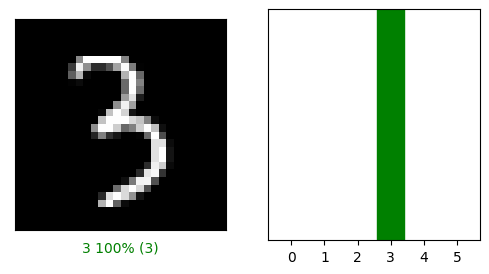

In [68]:
num = int(random.uniform(0, predictions.shape[0]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

## **SAVE ORIGINAL MODEL AND FROZEN MODEL**

In [69]:
# ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "/Original_model/" 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as original_mnist_cnn.h5')
# model_test.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")
# save_summary_model(model_test, ORIGINAL_MODEL_PATH, 0, "original")

model_test.save(SAVE_MODEL_PATH + "original_mnist_cnn.h5")
save_summary_model(model_test, SAVE_MODEL_PATH, 0, "original")

Test loss: 0.0031109543051570654
Test accuracy: 1.0
Save ORIGINAL MODEL as original_mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

### SAVE THE FROZEN MODEL

In [70]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

# FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_model/"

print('Save FROZEN MODEL model as frozen_mnist_cnn.h5')
#frozen_model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
#save_summary_model(frozen_model, FROZEN_MODEL_PATH, 1, "frozen")
frozen_model.save(SAVE_MODEL_PATH + "frozen_mnist_cnn.h5")
save_summary_model(frozen_model, SAVE_MODEL_PATH, 1, "frozen")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 8)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 10, 32)        2336      
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

### SAVE LL WEIGHTS (Last Layer)

Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [71]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')


# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(SAVE_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(SAVE_MODEL_PATH + 'll_biases.txt', 'w') as new_file:
    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (512, 6)
The shape of the last layer biases is: (6,)


### SAVE FEATURES

In [72]:
data_test = np.concatenate((data_low_test, data_high_test))
label_test = np.concatenate((label_low_test, label_high_test))

# Compute predictions
features = frozen_model.predict(data_test, verbose = False)

np.savetxt(SAVE_MODEL_PATH + 'll_features.txt', features, fmt='%.3f')

with open(SAVE_MODEL_PATH + 'll_features.txt', 'w') as new_file:
    for i in range(0, features.shape[0]):
        for j in range(0, features.shape[1]): 
            if features[i,j] != 0:
              str1 = '%.3f '%features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)           
        new_file.write('\n')     
new_file.close()

np.savetxt(SAVE_MODEL_PATH + 'll_labels_features.txt',label_test, fmt='%1d')

# Pruning mancante